In [1]:
%matplotlib inline
import os, sys
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import nuSQUIDSpy as nsq

units = nsq.Const()

e_nodes = np.geomspace(5, 200, 100)*units.GeV

neutrino_flavors = 4

distances = np.array([[10000., 2000.]]*len(e_nodes))*units.km
tot_distances = np.sum(distances, axis=1)
densities = np.array([[13., 5.]]*len(e_nodes))
ye = np.array([[.40, .45]]*len(e_nodes))

nus_layer = nsq.nuSQUIDSLayers(
    distances,
    densities,
    ye,
    e_nodes,
    neutrino_flavors,
    nsq.NeutrinoType.neutrino,
)


nus_layer.Set_MixingParametersToDefault()
nus_layer.Set_CPPhase(0, 2, 0)
nus_layer.Set_SquareMassDifference(3, 0.1 * units.eV)
nus_layer.Set_MixingAngle(1, 3, 0.2)
nus_layer.Set_MixingAngle(2, 3, 0)
nus_layer.Set_CPPhase(0, 3, 0)
nus_layer.Set_CPPhase(1, 3, 0)
nus_layer.Set_initial_state(np.array([0,1,0,0]), nsq.Basis.flavor)

nus_layer2 = nsq.nuSQUIDSLayers(
    distances,
    densities*ye,
    np.ones_like(ye),
    e_nodes,
    neutrino_flavors,
    nsq.NeutrinoType.neutrino,
)


nus_layer2.Set_MixingParametersToDefault()
nus_layer2.Set_CPPhase(0, 2, 0)
nus_layer2.Set_SquareMassDifference(3, 0.1 * units.eV)
nus_layer2.Set_MixingAngle(1, 3, 0.2)
nus_layer2.Set_MixingAngle(2, 3, 0)
nus_layer2.Set_CPPhase(0, 3, 0)
nus_layer2.Set_CPPhase(1, 3, 0)
nus_layer2.Set_initial_state(np.array([0,1,0,0]), nsq.Basis.flavor)

In [3]:
%%time
nus_layer.Set_rel_error(1.0e-5)
nus_layer.Set_abs_error(1.0e-5)
nus_layer.EvolveState()

CPU times: user 28.6 ms, sys: 0 ns, total: 28.6 ms
Wall time: 28.6 ms


In [4]:
%%time
nus_layer2.Set_rel_error(1.0e-5)
nus_layer2.Set_abs_error(1.0e-5)
nus_layer2.EvolveState()

CPU times: user 11.7 ms, sys: 0 ns, total: 11.7 ms
Wall time: 11.8 ms


In [5]:
#### get probs
e_output = np.geomspace(5, 200, 500)*units.GeV
interp_loge = True

distances = np.array([[10000]]*len(e_output))*units.km
tot_distances = np.sum(distances, axis=1)

evolved_states = nus_layer.GetStates()
interp_states = np.zeros((len(e_output), evolved_states.shape[1]))

for i in range(evolved_states.shape[1]):
    interp_states[:, i] = np.interp(np.log10(e_output), np.log10(e_nodes), evolved_states[:,i])
interp_states_first_evol = interp_states
prob_interp = nus_layer.EvalWithState(1, tot_distances, e_output, interp_states)

####### get probs 2
evolved_states = nus_layer2.GetStates()
interp_states = np.zeros((len(e_output), evolved_states.shape[1]))

for i in range(evolved_states.shape[1]):
    interp_states[:, i] = np.interp(np.log10(e_output), np.log10(e_nodes), evolved_states[:,i])
interp_states_first_evol = interp_states
prob_interp2 = nus_layer2.EvalWithState(1, tot_distances, e_output, interp_states)

Text(0, 0.5, '$P(\\nu_\\mu\\rightarrow\\nu_\\mu)$')

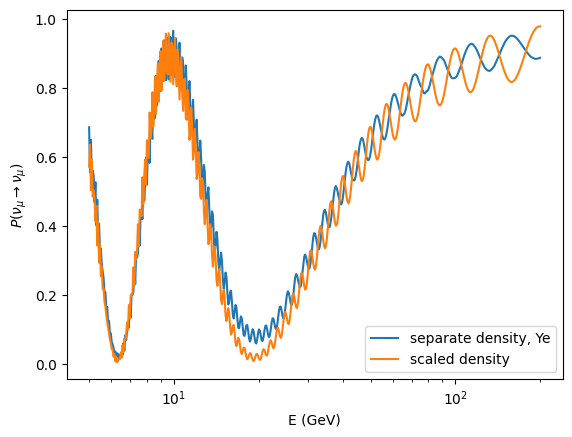

In [6]:
plt.plot((e_output/units.GeV), prob_interp, label="separate density, Ye")
plt.plot((e_output/units.GeV), prob_interp2, label="scaled density")
plt.semilogx()
plt.legend()
# plt.xlabel("L/E (km/GeV)")
plt.xlabel("E (GeV)")
plt.ylabel(r"$P(\nu_\mu\rightarrow\nu_\mu)$")

In [7]:
from pisa.stages.osc.layers import Layers
from pisa import ureg

earth_model = "/afs/ifh.de/user/t/trettin/scratch/pisa/pisa_examples/resources/osc/PREM_12layer.dat"
# electron densities
YeI = 0.4656
YeM = 0.4957
YeO = 0.4656

# height (units are assumed to be km by layers module)
detector_depth = 2.  # * ureg["km"]
prop_height = 20.  # * ureg["km"]

layers = Layers(earth_model, detector_depth, prop_height)
# layers.setElecFrac(YeI, YeO, YeM)
# we just want the matter density here without scaling for Ye
layers.setElecFrac(1., 1., 1.)


def calc_probs(
    e_nodes, e_output, flav=1, coszen=-1, theta24=0, theta34=0,
    deltacp14=0, deltacp24=0, antinu=False, dm41=1,
    eval_lp_cutoff=0.015 / units.km, eval_lp_frac=0.5,
    scaled_ye=False,
):

    neutrino_flavors = 4

    layers.calcLayers(np.array([coszen]))  # the same for all nodes here
    distances = np.broadcast_to(
        layers.distance,
        (len(e_nodes), layers.max_layers),
    )
    densities = np.broadcast_to(
        layers.density,
        (len(e_nodes), layers.max_layers),
    )
    # HACK: Need to do the electron fraction thing correctly.
    # Density > 10 g/cm^3 indicates we are in the core
    ye = np.zeros_like(densities)
    ye[densities < 10] = YeM
    ye[(densities >= 10) & (densities < 13)] = YeO
    ye[densities >= 13] = YeI

    nus = nsq.nuSQUIDSLayers(
        distances*units.km,
        densities * ye if scaled_ye else densities,
        np.ones_like(ye) if scaled_ye else ye,
        e_nodes,
        neutrino_flavors,
        nsq.NeutrinoType.antineutrino if antinu else nsq.NeutrinoType.neutrino,
    )

    nus.Set_MixingParametersToDefault()
    nus.Set_CPPhase(0, 2, 0)
    nus.Set_SquareMassDifference(3, dm41)
    #nus.Set_MixingAngle(1, 2, np.arcsin(np.sqrt(0.56)))
    nus.Set_MixingAngle(1, 3, theta24)
    nus.Set_MixingAngle(2, 3, theta34)
    nus.Set_CPPhase(0, 3, deltacp14)
    nus.Set_CPPhase(1, 3, deltacp24)

    inistate = np.zeros(neutrino_flavors)
    inistate[flav] = 1
    nus.Set_initial_state(inistate, nsq.Basis.flavor)
    nus.Set_rel_error(1.0e-7)
    nus.Set_abs_error(1.0e-7)
    
    nus_layer.Set_EvolLowPassCutoff(0.015 / units.km)
    nus_layer.Set_EvolLowPassScale(0.0015  / units.km)
    
    nus.EvolveState()

    distances = np.broadcast_to(
        layers.distance,
        (len(e_output), layers.max_layers),
    )*units.km
    tot_distances = np.sum(distances, axis=1)

    evolved_states = nus.GetStates()
    interp_states = np.zeros((len(e_output), evolved_states.shape[1]))

    for i in range(evolved_states.shape[1]):
        interp_states[:, i] = np.interp(
            np.log10(e_output), np.log10(e_nodes), evolved_states[:, i])

    return nus.EvalWithState(
        flav,
        tot_distances,
        e_output,
        interp_states,
        avg_cutoff=0.,
        avg_scale=0.,
        rho=0,
        t_range=0,
        lowpass_cutoff=eval_lp_cutoff,
        lowpass_scale=eval_lp_cutoff * eval_lp_frac,
    )

<< PISA is running in double precision (FP64) mode; numba is running on CPU (single core) >>


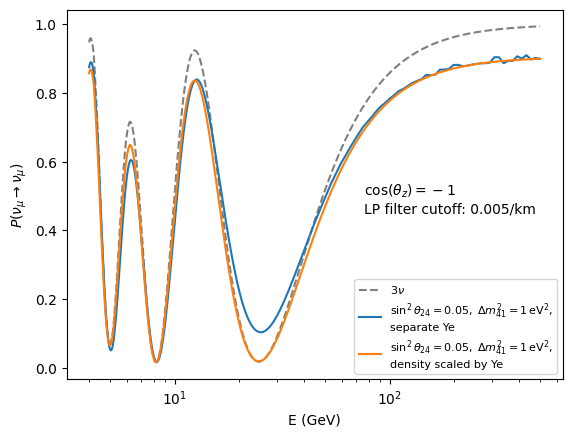

In [8]:
e_nodes = np.geomspace(4, 500, 100)*units.GeV
e_output = np.geomspace(4, 500, 1000)*units.GeV

probs = calc_probs(e_nodes, e_output)
plt.plot(e_output/units.GeV, probs, label=r"$3\nu$", color="gray", linestyle="--")

eval_lp_cutoff = 0.005
sin2th = 0.05
th = np.arcsin(np.sqrt(sin2th))
dm41 = 1
probs = calc_probs(e_nodes, e_output, theta24=th, theta34=0, dm41=dm41,
                   eval_lp_cutoff=eval_lp_cutoff/units.km)
plt.plot(e_output/units.GeV, probs,
         label=(fr"$\sin^2\theta_{{24}}={sin2th},\;"
                # r"\theta_{{34}}=0^\circ,\;"
                fr"\Delta m^2_{{41}}={dm41}\,\mathrm{{eV^2}}$"+",\nseparate Ye"))

sin2th = 0.05
th = np.arcsin(np.sqrt(sin2th))
dm41 = 1
probs = calc_probs(e_nodes, e_output, theta24=th, theta34=0, dm41=dm41,
                   scaled_ye=True, eval_lp_cutoff=eval_lp_cutoff/units.km)
plt.plot(e_output/units.GeV, probs,
         label=(fr"$\sin^2\theta_{{24}}={sin2th},\;"
                # r"\theta_{{34}}=0^\circ,\;"
                fr"\Delta m^2_{{41}}={dm41}\,\mathrm{{eV^2}}$"+",\ndensity scaled by Ye"))
plt.semilogx()
plt.legend(fontsize=8)
plt.xlabel("E (GeV)")
plt.ylabel(r"$P(\nu_\mu\rightarrow\nu_\mu)$")
plt.text(.6, .45,
         r"$\cos(\theta_z)=-1$"+"\n"
         f"LP filter cutoff: {eval_lp_cutoff}/km",
         transform=plt.gca().transAxes)
plt.savefig("ye_scale_effect.pdf")

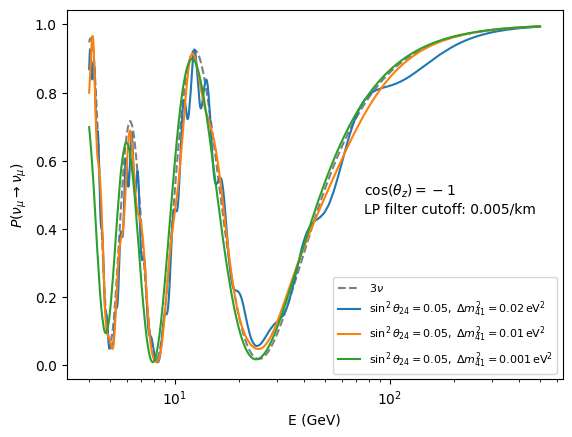

In [9]:
e_nodes = np.geomspace(4, 500, 100)*units.GeV
e_output = np.geomspace(4, 500, 1000)*units.GeV

probs = calc_probs(e_nodes, e_output)
plt.plot(e_output/units.GeV, probs, label=r"$3\nu$", color="gray", linestyle="--")

# sin2th = 0.05
# th = np.arcsin(np.sqrt(sin2th))
# dm41 = 1
# probs = calc_probs(e_nodes, e_output, theta24=th, theta34=0, dm41=dm41)
# plt.plot(e_output/units.GeV, probs,
#          label=(fr"$\sin^2\theta_{{24}}={sin2th},\;"
#                 # r"\theta_{{34}}=0^\circ,\;"
#                 fr"\Delta m^2_{{41}}={dm41}\,\mathrm{{eV^2}}$"))

sin2th = 0.05
th = np.arcsin(np.sqrt(sin2th))
dm41 = 0.02
probs = calc_probs(e_nodes, e_output, theta24=th, theta34=0, dm41=dm41)
plt.plot(e_output/units.GeV, probs,
         label=(fr"$\sin^2\theta_{{24}}={sin2th},\;"
                # r"\theta_{{34}}=0^\circ,\;"
                fr"\Delta m^2_{{41}}={dm41}\,\mathrm{{eV^2}}$"))

sin2th = 0.05
th = np.arcsin(np.sqrt(sin2th))
dm41 = 0.01
probs = calc_probs(e_nodes, e_output, theta24=th, theta34=0, dm41=dm41)
plt.plot(e_output/units.GeV, probs,
         label=(fr"$\sin^2\theta_{{24}}={sin2th},\;"
                # r"\theta_{{34}}=0^\circ,\;"
                fr"\Delta m^2_{{41}}={dm41}\,\mathrm{{eV^2}}$"))

sin2th = 0.05
th = np.arcsin(np.sqrt(sin2th))
dm41 = 0.001
probs = calc_probs(e_nodes, e_output, theta24=th, theta34=0, dm41=dm41)
plt.plot(e_output/units.GeV, probs,
         label=(fr"$\sin^2\theta_{{24}}={sin2th},\;"
                # r"\theta_{{34}}=0^\circ,\;"
                fr"\Delta m^2_{{41}}={dm41}\,\mathrm{{eV^2}}$"))

plt.semilogx()
plt.legend(fontsize=8)
plt.xlabel("E (GeV)")
plt.ylabel(r"$P(\nu_\mu\rightarrow\nu_\mu)$")
plt.text(.6, .45,
         r"$\cos(\theta_z)=-1$"+"\n"
         "LP filter cutoff: 0.005/km",
         transform=plt.gca().transAxes)
plt.savefig("sterile_probs_lowdm41_oversmooth.pdf")

## Reproducing figures from paper
Attempt to approximately reproduce figures from https://pos.sissa.it/358/870/pdf. 

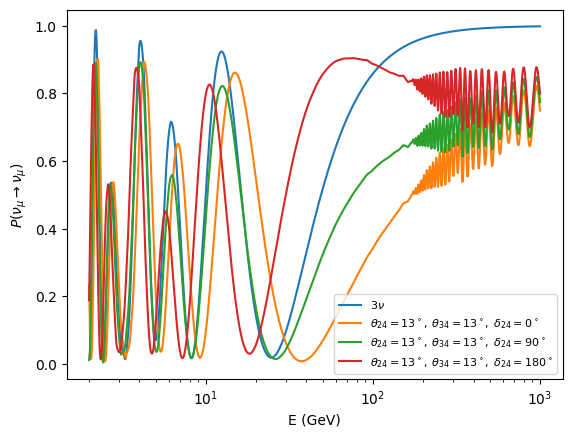

In [10]:
e_nodes = np.geomspace(2, 1e3, 100)*units.GeV
e_output = np.geomspace(2, 1e3, 1000)*units.GeV

probs = calc_probs(e_nodes, e_output)
plt.plot(e_output/units.GeV, probs, label=r"$3\nu$")

th = np.arcsin(np.sqrt(0.05))
probs = calc_probs(e_nodes, e_output, theta24=th, theta34=th)
plt.plot(e_output/units.GeV, probs,
         label=(fr"$\theta_{{24}}={th*180/np.pi:.2g}^\circ,\;"
                fr"\theta_{{34}}={th*180/np.pi:.2g}^\circ,\;"
                r"\delta_{{24}}=0^\circ$"))
probs = calc_probs(e_nodes, e_output, theta24=th, theta34=th, deltacp24=90*np.pi/180)
plt.plot(e_output/units.GeV, probs,
         label=(fr"$\theta_{{24}}={th*180/np.pi:.2g}^\circ,\;"
                fr"\theta_{{34}}={th*180/np.pi:.2g}^\circ,\;"
                r"\delta_{{24}}=90^\circ$"))
probs = calc_probs(e_nodes, e_output, theta24=th, theta34=th, deltacp24=180*np.pi/180)
plt.plot(e_output/units.GeV, probs,
         label=(fr"$\theta_{{24}}={th*180/np.pi:.2g}^\circ,\;"
                fr"\theta_{{34}}={th*180/np.pi:.2g}^\circ,\;"
                r"\delta_{{24}}=180^\circ$"))

plt.semilogx()
plt.legend(fontsize=8)
# plt.xlabel("L/E (km/GeV)")
plt.xlabel("E (GeV)")
plt.ylabel(r"$P(\nu_\mu\rightarrow\nu_\mu)$")
plt.savefig("fig3a_ANTARES_paper_reprod.png", dpi=200)

Text(0, 0.5, '$P(\\bar{\\nu}_\\mu\\rightarrow\\bar{\\nu}_\\mu)$')

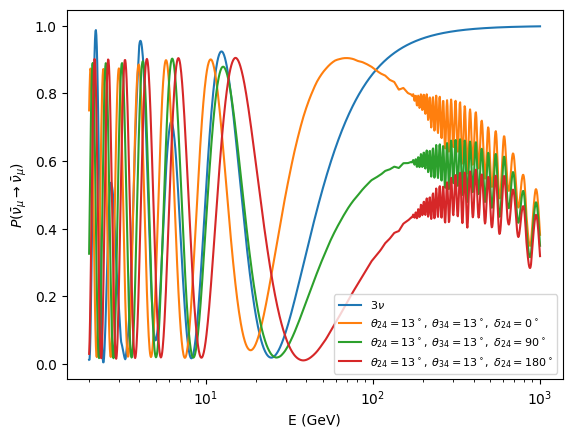

In [18]:
e_nodes = np.geomspace(2, 1e3, 100)*units.GeV
e_output = np.geomspace(2, 1e3, 1000)*units.GeV

probs = calc_probs(e_nodes, e_output)
plt.plot(e_output/units.GeV, probs, label=r"$3\nu$")

th = np.arcsin(np.sqrt(0.05))
probs = calc_probs(e_nodes, e_output, theta24=th, theta34=th, antinu=True)
plt.plot(e_output/units.GeV, probs,
         label=(fr"$\theta_{{24}}={th*180/np.pi:.2g}^\circ,\;"
                fr"\theta_{{34}}={th*180/np.pi:.2g}^\circ,\;"
                r"\delta_{{24}}=0^\circ$"))
probs = calc_probs(e_nodes, e_output, theta24=th, theta34=th, deltacp24=90*np.pi/180, antinu=True)
plt.plot(e_output/units.GeV, probs,
         label=(fr"$\theta_{{24}}={th*180/np.pi:.2g}^\circ,\;"
                fr"\theta_{{34}}={th*180/np.pi:.2g}^\circ,\;"
                r"\delta_{{24}}=90^\circ$"))
probs = calc_probs(e_nodes, e_output, theta24=th, theta34=th, deltacp24=180*np.pi/180, antinu=True)
plt.plot(e_output/units.GeV, probs,
         label=(fr"$\theta_{{24}}={th*180/np.pi:.2g}^\circ,\;"
                fr"\theta_{{34}}={th*180/np.pi:.2g}^\circ,\;"
                r"\delta_{{24}}=180^\circ$"))

# probs = calc_probs(e_nodes, e_output, theta24=20.8*np.pi/180, theta34=31.2*np.pi/180)
# plt.plot(e_output/units.GeV, probs,
#          label=r"$\theta_{24}=20.8^\circ,\;\theta_{34}=31.2^\circ$")
# probs = calc_probs(e_nodes, e_output,
#                    deltacp24=90*np.pi/180,
#                    theta24=20.8*np.pi/180,
#                    theta34=31.2*np.pi/180)
# plt.plot(1300 / (e_output/units.GeV), probs,
#          label=r"$\theta_{24}=20.8^\circ,\;\theta_{34}=31.2^\circ,\;\delta_{24}=90^\circ$")

plt.semilogx()
plt.legend(fontsize=8)
# plt.xlabel("L/E (km/GeV)")
plt.xlabel("E (GeV)")
plt.ylabel(r'$P(\bar{\nu}_\mu\rightarrow\bar{\nu}_\mu)$')
# plt.savefig("fig3b_ANTARES_paper_reprod.png", dpi=200)

In [12]:
from pisa.stages.osc.layers import Layers
from pisa import ureg

earth_model = "/afs/ifh.de/user/b/buchholl/scratch/software/pisa/pisa_examples/resources/osc/PREM_12layer.dat"
# electron densities
YeI = 0.4656
YeM = 0.4957
YeO = 0.4656

# height (units are assumed to be km by layers module)
detector_depth = 2. # * ureg["km"]
prop_height = 20. # * ureg["km"]

layers = Layers(earth_model, detector_depth, prop_height)
# layers.setElecFrac(YeI, YeO, YeM)
# we just want the matter density here without scaling for Ye
layers.setElecFrac(1., 1., 1.)

In [13]:
import nuSQUIDSpy as nsq

units = nsq.Const()

def calc_tot_distance(coszen):
    """
    Calculate total distances for given array of coszen.
    
    This is needed for evaluation of interpolated states.
    """
    cos_arr = np.atleast_1d(coszen)
    layers.calcLayers(cos_arr)
    distances = layers.distance.reshape((len(cos_arr), layers.max_layers))
    return np.sum(distances, axis=1) * units.km

def make_nus_layer(e_nodes, neutrino_flavors, interactions, coszen=-1., return_tot_lens=False):
    layers.calcLayers(np.array([coszen]))  # the same for all nodes here
    distances = np.broadcast_to(
        layers.distance,
        (len(e_nodes), layers.max_layers),
    )
    densities = np.broadcast_to(
        layers.density,
        (len(e_nodes), layers.max_layers),
    )
    # HACK: Need to do the electron fraction thing correctly.
    # Density > 10 g/cm^3 indicates we are in the core
    ye = np.zeros_like(densities)
    ye[densities < 10] = YeM
    ye[(densities >= 10) & (densities < 13)] = YeO
    ye[densities >= 13] = YeI
    nus_layer = nsq.nuSQUIDSLayers(
        distances*units.km,
        densities,
        ye,
        e_nodes,
        neutrino_flavors,
        nsq.NeutrinoType.neutrino,
    )
    
    if return_tot_lens:
        tot_lens = np.sum(distances, axis=1) * units.km  # total times
        return nus_layer, tot_lens
    else:
        return nus_layer

In [14]:
def get_interpolated_states(nus_layer, e_nodes, e_output, interp_loge=True):
    # interpolation here, supporting different methods
    evolved_states = nus_layer.GetStates()
    interp_states = np.zeros((len(e_output), evolved_states.shape[1]))
    e_interp = e_output
    if interp_loge:
        e_interp = np.log10(e_output)
        e_nodes = np.log10(e_nodes)
    for i in range(evolved_states.shape[1]):
        interp_states[:, i] = np.interp(e_interp, e_nodes, evolved_states[:,i])
    return interp_states

def calc_probs_interp(
    e_output, e_nodes, steriles=False, return_nus=False,
    interp_loge=True,
    lp_cutoff=0., lp_scale=0.,
    sterile_deltam=1, coszen=-1,
    theta24=0.3, theta34=0.1,
    deltacp14=0, deltacp24=0,
):
    n_flav = 4 if steriles else 3
    nus_layer, tot_lens = make_nus_layer(e_nodes, n_flav, False, coszen=coszen, return_tot_lens=True)
    nus_layer.Set_MixingParametersToDefault()
    ini_state = [0, 1, 0]
    if steriles:
        nus_layer.Set_SquareMassDifference(3, sterile_deltam)
        nus_layer.Set_MixingAngle(1, 3, 0.3)
        nus_layer.Set_MixingAngle(2, 3, 0.3)
        nus_layer.Set_CPPhase(0, 3, deltacp14)
        nus_layer.Set_CPPhase(1, 3, deltacp24)
        ini_state += [0]
    
    nus_layer.Set_initial_state(np.array(ini_state), nsq.Basis.flavor)
    nus_layer.Set_AllowConstantDensityOscillationOnlyEvolution(False)
    
    nus_layer.Set_rel_error(1.0e-7)
    nus_layer.Set_abs_error(1.0e-7)
    
    nus_layer.EvolveState()
    
    out_tot_lens = calc_tot_distance(np.broadcast_arrays(coszen, e_output)[0])
    # interpolation here, supporting different methods
    interp_states = get_interpolated_states(nus_layer, e_nodes, e_output)
    '''
    prob_interp = nus_layer.EvalWithState(
        1,
        np.ones_like(e_output)*tot_lens[0],
        e_output,
        interp_states,
        rho=0,
        #avg_cutoff=0 
        avr_scale=0,
        #t_range=0
        lowpass_cutoff=lp_cutoff,
        lowpass_scale=lp_scale,
    )
    '''
    
    prob_interp = nus_layer.EvalWithState(
        1,
        np.ones_like(e_output)*tot_lens[0],
        e_output,
        interp_states,
        0,
        0,
        0,
        0,
        lp_cutoff,
        lp_scale,
    )
    
    if return_nus:
        return prob_interp, nus_layer
    else:
        return prob_interp

In [15]:
plot_e = np.geomspace(8, 200, 1000) * units.GeV
e_nodes = np.geomspace(8, 200, 50) * units.GeV

In [16]:
# %%time
# probs_interp, nus_layer = calc_probs_interp(
#     plot_e, e_nodes,
#     return_nus=True,
#     steriles=True,
#     deltacp14=10 * np.pi/180,
#     # lp_cutoff=0.015 / units.km,
#     # lp_scale=0.015/2 / units.km,
# )

[ WARNING] /afs/ifh.de/group/amanda/scratch/buchholl/software/snuvenv/lib/python3.10/site-packages/numba/core/typing/typeof.py:250: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  readonly = not val.flags.writeable



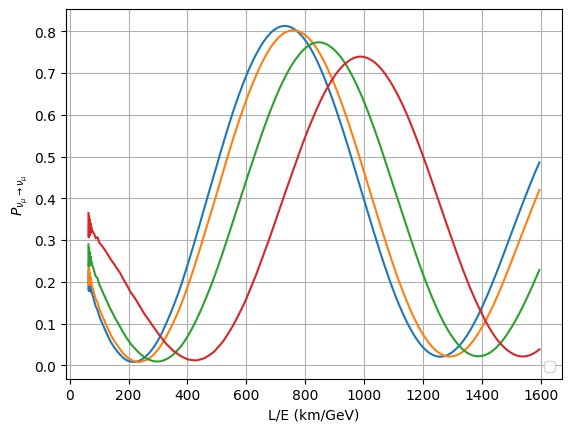

In [17]:
#avr_cutoff, t_range missing in evalflavorwithstate

probs_cp14_0 = calc_probs_interp(
    plot_e, e_nodes,
    steriles=True,
    deltacp24=0 * np.pi/180,
    lp_cutoff=0.015 / units.km,
    lp_scale=0.015/2 / units.km,
)

probs_cp14_30 = calc_probs_interp(
    plot_e, e_nodes,
    steriles=True,
    deltacp24=30 * np.pi/180,
    #deltacp14=30 * np.pi/180,
    lp_cutoff=0.015 / units.km,
    lp_scale=0.015/2 / units.km,
)

probs_cp14_60 = calc_probs_interp(
    plot_e, e_nodes,
    steriles=True,
    deltacp24=60 * np.pi/180,
    lp_cutoff=0.015 / units.km,
    lp_scale=0.015/2 / units.km,
)

probs_cp14_90 = calc_probs_interp(
    plot_e, e_nodes,
    steriles=True,
    deltacp24=90 * np.pi/180,
    lp_cutoff=0.015 / units.km,
    lp_scale=0.015/2 / units.km,
)

plot_l = calc_tot_distance(-1)/units.km

plt.plot(plot_l / (plot_e/units.GeV), probs_cp14_0)
plt.plot(plot_l / (plot_e/units.GeV), probs_cp14_30)
plt.plot(plot_l / (plot_e/units.GeV), probs_cp14_60)
plt.plot(plot_l / (plot_e/units.GeV), probs_cp14_90)

# plt.semilogx()
plt.legend(loc="lower right")
plt.ylabel(r"$P_{\nu_\mu\rightarrow\nu_\mu}$")

plt.xlabel("L/E (km/GeV)")
plt.grid()